# The material presented in this notebook is for using in Introduction to Deep Learning (ECE 685D) course, Duke University, Fall 2023.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# First: a detour to CNN normalization methods

## Local Contrast Normalization

## Batch Normalization

### Intuition
1. Neuron activations having different distributions/ranges of values between layers can add a lot of difficulty to training, making networks more brittle.
2. We can make these activations have a standard normal distribution with a very simple technique!
3. Can help with faster convergence, and general training improvements and consistency.
4. This also makes networks less sensitive to initialization (which PyTorch already takes care of by default https://pytorch.org/docs/1.5.1/nn.init.html#nn-init-doc).

### How it works (training)

During training, for each layer's output activations, we accumulate the moving average and variance of all neurons, normalize each of them by this, and then *scale* and *bias* the activations with *learned* parameters $\gamma$ and $\beta$. All of this is done within a batch norm layer $\mathrm{BN}_{\gamma,\beta}$ after each standard neural net layer (from lecture below):

<!-- ![batchnorm_lectureshot.png](batchnorm_lectureshot.png) -->
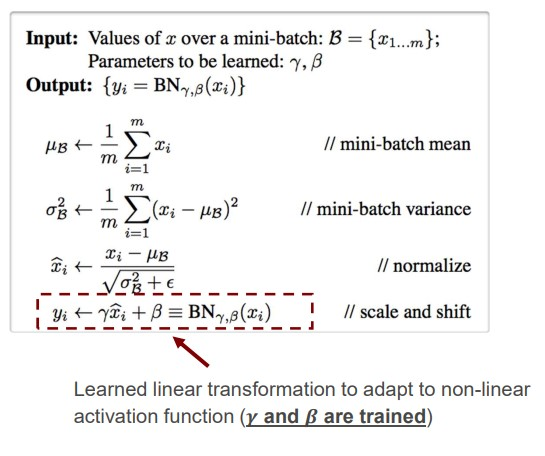



This is super easy to do in PyTorch: use `torch.nn.BatchNorm2d` after convolutional layers, and `torch.nn.BatchNorm1d` after fully connected layers. (An example is given further into this notebook).


### How does backpropagation work with batch norm?
A good way to visualize backprop is via a forward and backward pass *computational graph* (from https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html):



<!-- ![BNcircuit.png](BNcircuit.png) -->
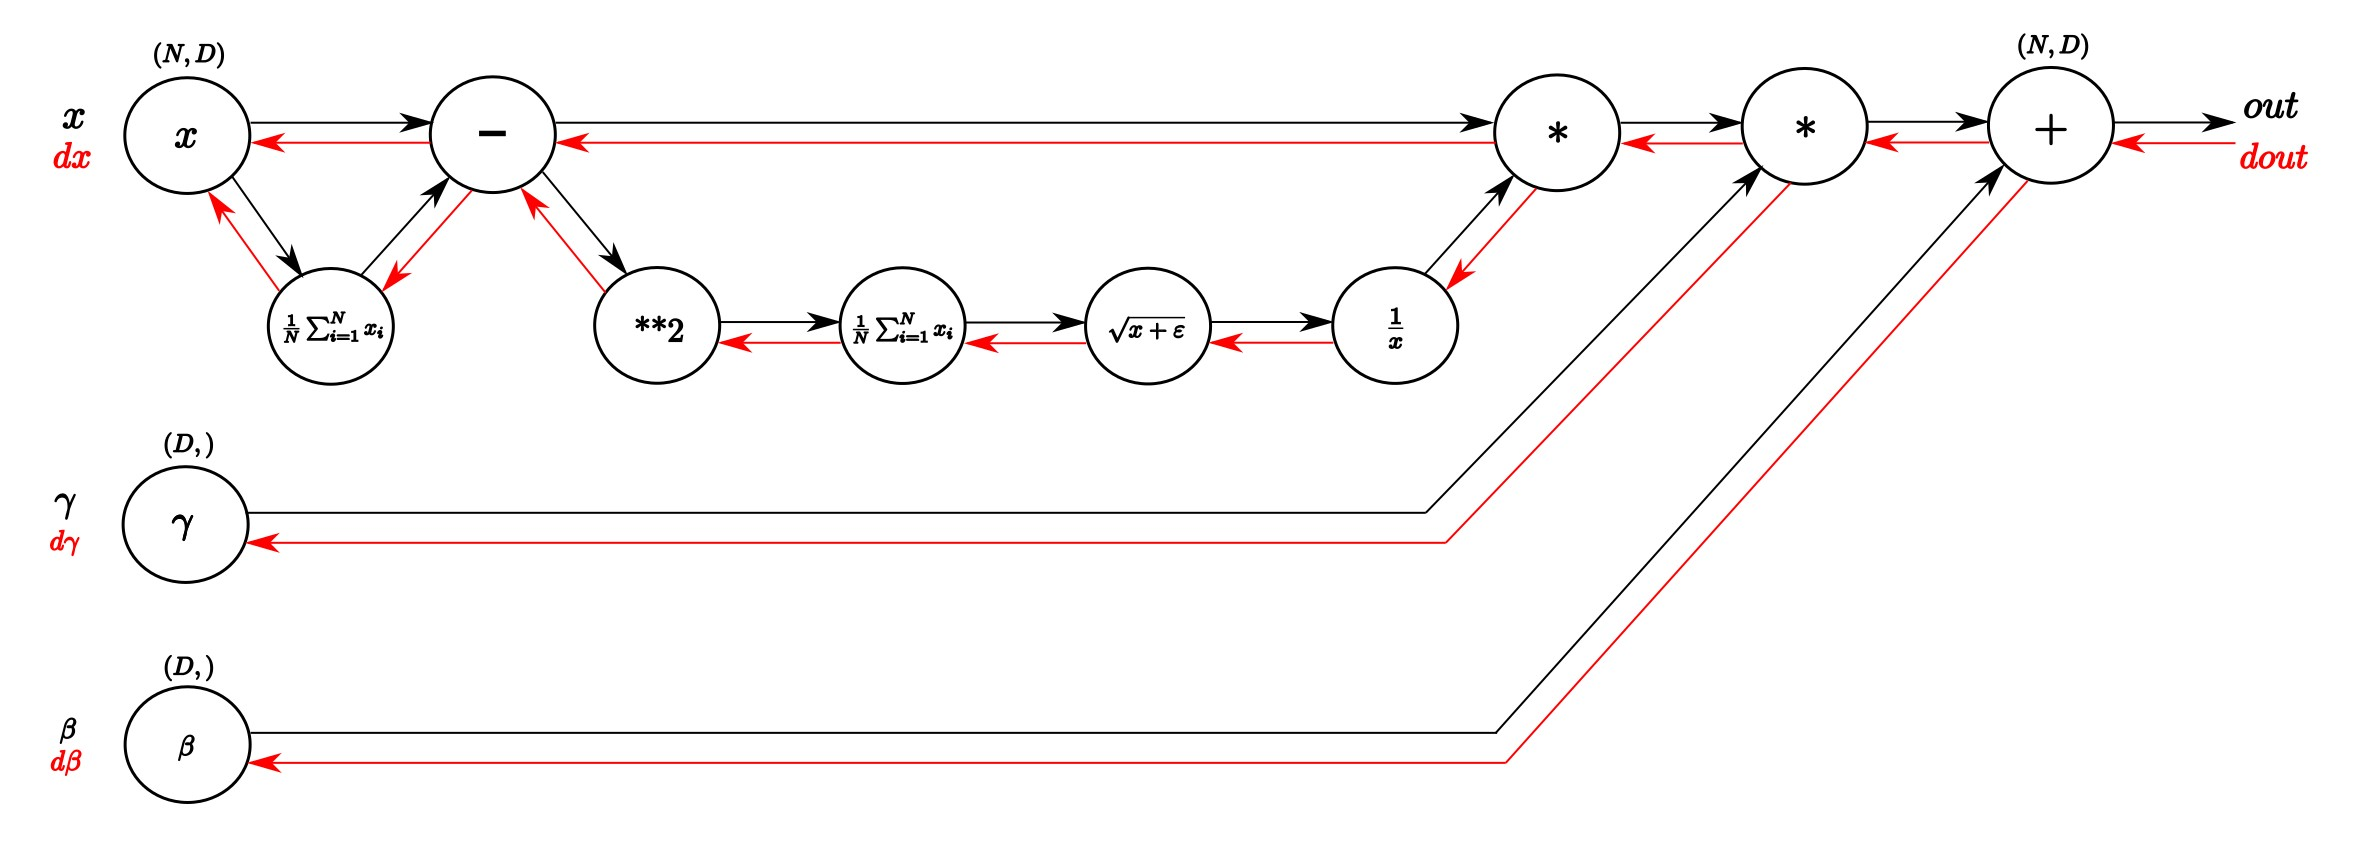

Key takeaways:
For the forward pass, follow the black arrows from the left:
1. The top branch shows the computation of the mean and variance of the activations $x$, and the subtraction of the mean and division by the variance on $x$.
2. The bottom two branches just show the learnable scale and shift/bias parameters $\gamma$ and $\beta$.
3. Finally, all branches combine near the end to scale and shift the normalized activations with the learnable parameters $\gamma$ and $\beta$.
The backward pass just follows the red arrows from the right! Simple follow the arrows and use the chain rule to compute $d\mathrm{out}/d\gamma=dy/d\gamma$, $d\mathrm{out}/d\beta=dy/d\beta$, and $d\mathrm{out}/dx=dy/dx$.




### But what about during the *test phase*?
1. Recall that we can't use information from the test set to modify/finetune the network! So, when doing a forward pass on test data, just use the running average and variance estimates of the *training set*.
2. This is taken care of automatically in PyTorch when you switch from `net.train()` to `net.eval()`, similar to `torch.nn.Dropout`.

### Basic example
Let's show how BatchNorm works on a batch of randomly initialized data:

In [ ]:
m = nn.BatchNorm1d(50, affine=False) # Use BN Without Learnable Parameters

# initialize 20 batches of data with 50 features, from a uniform dist.
input = torch.rand(20, 50)
output = m(input)

n, bins, patches = plt.hist(input, 10, facecolor='g', alpha=0.75, label='before BN')
plt.xlabel('activation value')
plt.legend()
plt.show()

n, bins, patches = plt.hist(output, 10, facecolor='r', alpha=0.75, label='after BN')
plt.xlabel('activation value')
plt.legend()
plt.show()

## Implementation Example of Batch Norm Layer in a Neural Network
Let's use the basic CNN example (LetNet) from Discussion Section 4, but with batch norm added!

In [ ]:
batch_size = 100
train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])
train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

This will be the same model as in Discussion Section 4, but with Batch Norm layers added!

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.bn_conv1 = nn.BatchNorm2d(6) # num_features for BatchNorm2d is number of output channels of previous layers
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.bn_conv2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(in_features=16*5*5, out_features=120)
        self.bn_fc1 = nn.BatchNorm1d(120)
        self.fc2   = nn.Linear(in_features=120, out_features=84)
        self.bn_fc2 = nn.BatchNorm1d(84)
        self.fc3   = nn.Linear(in_features=84, out_features=out_channels)
        # don't need batch norm after last lyr

    def forward(self, x):
        # now lets add the batch norm call
        # typically done before the nonlinearity
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        # don't need batch norm after last lyr
        return x

From here, training and testing is exactly the same as in Discussion Section 4.

<!-- <img src="./AE.png" width="800"> -->
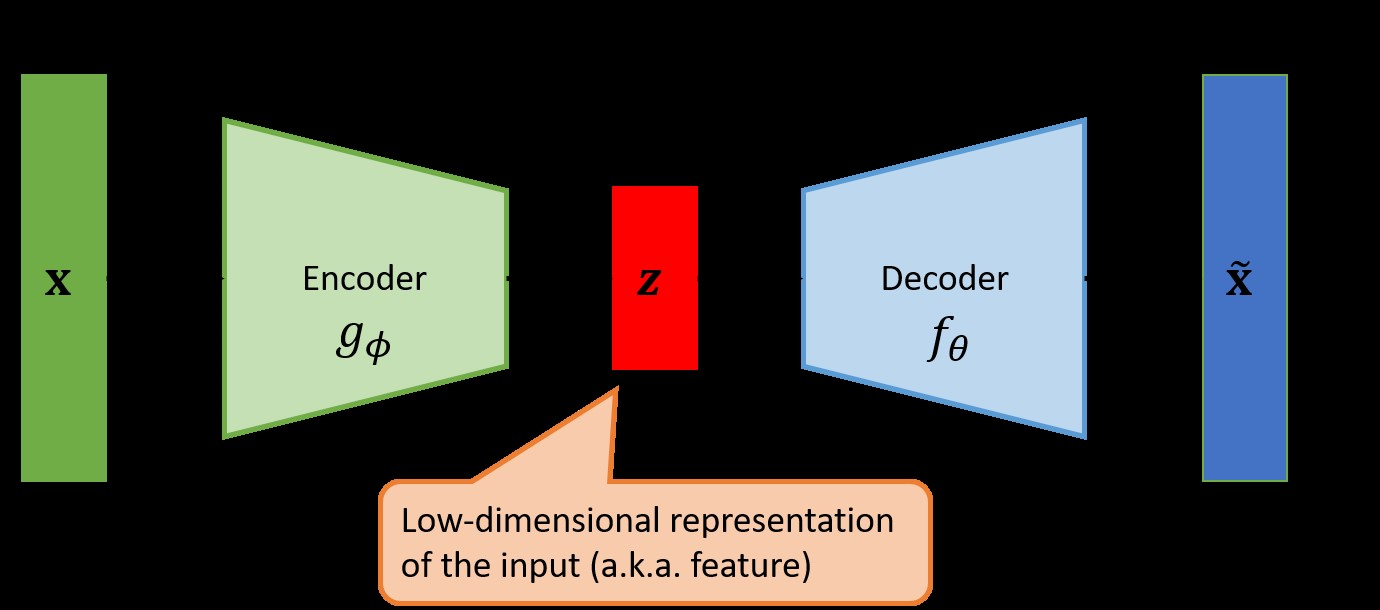


An Autoencoder (AE) consists of en encoder and a decoder.
The encoder maps the input $\mathbf{x}$ to a lower dimensional representation $\mathbf{z} = g_\phi(\mathbf{x})$, whereas the decoder reconstructs $\mathbf{x}$ through $\tilde{\mathbf{x}}=f_\theta(\mathbf{z}) = f_\theta(g_\phi(\mathbf{x}))$.

## __Convolutional Autoencoder__

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        # this implementation can be found in the lecture slides on Autoencoders
        # the encoder/decoder are designed through two convolutional layers each.
        super(ConvAutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1), # for MNIST the size of the output after this layer is 10 X 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), # 5 X 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1), # 3 X 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1) # 2 X 2
        )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), # 5 X 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # 15 X 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # 28 X 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

## __Autoencoder with MLPs__

In [ ]:
class MLPAutoEncoder(nn.Module):
    def __init__(self, encode_layer_dims, decode_layer_dims):
        # len(encode_layer_dims)>=2, len(decode_layer_dims)>=2
        # encode_layer_dims[0] = dimension of the flattened input (28*28 for MNIST)
        # encode_layer_dims[-1] = decode_layer_dims[0] = dimension of the feature space
        # decode_layer_dims[-1] = dimension of the flattened output, i.e., input (28*28 for MNIST)
        super(MLPAutoEncoder, self).__init__()
        self.enc_l = len( encode_layer_dims )
        self.dec_l = len( decode_layer_dims )
        self.encoder = nn.ModuleList([ nn.Linear( encode_layer_dims[i], encode_layer_dims[i+1] ) for i in range(self.enc_l) if i <= self.enc_l-2 ])
        self.decoder = nn.ModuleList([ nn.Linear( decode_layer_dims[i], decode_layer_dims[i+1] ) for i in range(self.dec_l) if i <= self.dec_l-2 ])

    def forward(self, X):
        for i, enc_layer in enumerate(self.encoder):
            if i < self.enc_l - 2:
                X = F.relu(enc_layer(X))
            else:
                X = enc_layer(X)
        for i, dec_layer in enumerate(self.decoder):
            if i < self.dec_l - 2:
                X = F.relu(dec_layer(X))
            else:
                X = dec_layer(X)
        return X

## __Loading MNIST dataset and helper function for generating image__

In [ ]:
batch_size = 128
Num_epoch = 20
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

TrainingData = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
TestingData = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
TrainingLoader = torch.utils.data.DataLoader(TrainingData, batch_size=batch_size, shuffle=True, num_workers=0)
TestingLoader = torch.utils.data.DataLoader(TestingData, batch_size=100, shuffle=True, num_workers=0)

def Array_to_Image(x):
    x = 0.5*x + 0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x

## __Training and saving the best model__

In [ ]:
ConvAE_model = ConvAutoEncoder()
MLPAE_model = MLPAutoEncoder( [28*28, 150, 20], [20, 150, 28*28] )

ConvAE_model = ConvAE_model.to(device)
MLPAE_model = MLPAE_model.to(device)

criterion  = nn.MSELoss()
min_loss_ConvAE = 10e+10
min_loss_MLPAE = 10e+10

optConvAE = optim.Adam(ConvAE_model.parameters(), lr= 1e-3, weight_decay= 1e-4)
optMLPAE = optim.Adam(MLPAE_model.parameters(), lr= 1e-3, weight_decay= 1e-4)

for epoch in range(Num_epoch):

    training_loss_ConvAE = 0
    training_loss_MLPAE = 0

    for batch_ind, (image,_) in enumerate(TrainingLoader):

        image = image.to(device)

        # ConvAE model
        optConvAE.zero_grad()
        out_ConvAE = ConvAE_model(image)
        loss_ConvAE = criterion(image, out_ConvAE)
        loss_ConvAE.backward()
        optConvAE.step()
        training_loss_ConvAE += loss_ConvAE.item()

        # MLPAE model
        optMLPAE.zero_grad()
        out_MLPAE = MLPAE_model(image.view(image.size(0),-1))
        loss_MLPAE = criterion(image.view(image.size(0),-1), out_MLPAE)
        loss_MLPAE.backward()
        optMLPAE.step()
        training_loss_MLPAE += loss_MLPAE.item()

    print('Epoch: {}, Training ConvAE/MLPAE Loss: {}/{}'.format(epoch, training_loss_ConvAE, training_loss_MLPAE))

    ReconImg_ConvAE = Array_to_Image(out_ConvAE)
    # save_image(ReconImg_ConvAE, './Image_gen/ReconImg_{}_ConvAE.png'.format(epoch))
    save_image(ReconImg_ConvAE, './ReconImg_{}_ConvAE.png'.format(epoch))
    ReconImg_MLPAE = Array_to_Image(out_MLPAE)
    # save_image(ReconImg_MLPAE, './Image_gen/ReconImg_{}_MLPAE.png'.format(epoch))
    save_image(ReconImg_MLPAE, './ReconImg_{}_MLPAE.png'.format(epoch))

    if (training_loss_ConvAE/(batch_ind+1)) < min_loss_ConvAE:
        torch.save(ConvAE_model.state_dict(), 'ckpt_ConvAE.pth')
        min_loss_ConvAE = training_loss_ConvAE/(batch_ind+1)

    if (training_loss_MLPAE/(batch_ind+1)) < min_loss_MLPAE:
        torch.save(MLPAE_model.state_dict(), 'ckpt_MLPAE.pth')
        min_loss_MLPAE = training_loss_MLPAE/(batch_ind+1)

print('Done training!')

## __Loading the pre_trained MNIST classifier (LeNet5)__

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.fc1   = nn.Linear(in_features=16*5*5, out_features=120) if data_name == 'mnist' else nn.Linear(in_features=16*6*6, out_features=120)
        self.fc2   = nn.Linear(in_features=120, out_features=84)
        self.fc3   = nn.Linear(in_features=84, out_features=out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
clf = torch.load('ckpt_mnist_classifier.pth')#, map_location='cpu')

## __Function for computing the test accuracy__

In [ ]:
def test_clf(model, device, data, target):
    model.eval()
    correct = 0
    with torch.no_grad():
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(data)

## __Classifying 100 reconstructed MNIST images from the test set using clf__

In [ ]:
iter_test = iter(TestingLoader)
image_test, label_test = next(iter_test)
image_test = image_test.to(device)

ConvAE_model = ConvAutoEncoder().to(device)
MLPAE_model = MLPAutoEncoder([28*28, 150, 20], [20, 150, 28*28]).to(device)

ConvAE_model.load_state_dict(torch.load('ckpt_ConvAE.pth'))
MLPAE_model.load_state_dict(torch.load('ckpt_MLPAE.pth'))

with torch.no_grad():

    ConvAE_model.eval()
    out_ConvAE = ConvAE_model(image_test)
    image_ConvAE = Array_to_Image(out_ConvAE)

    MLPAE_model.eval()
    out_MLPAE = MLPAE_model(image_test.view(image_test.size(0),-1))
    image_MLPAE = Array_to_Image(out_MLPAE)


print('Classification accuracy for reconstructed images using ConvAE/MLPAE: {}/{}'.format( test_clf(clf, device, image_ConvAE, label_test), test_clf(clf, device, image_MLPAE, label_test) ) )
print('Classification accuracy for true images: {}'.format(test_clf(clf, device, image_test, label_test)))


# Notes and Further Reading

## Alternatives to MSE Loss for Regression

MSE loss has limitations that can severely impact model performance (e.g. it struggles to capture phase information in periodic signals). Therefore, one key challenge in training auto-encoders and other DNN architectures on regression problems is selecting the proper loss function. Here are some resources that discuss alternative loss functions to the MSE objective:

 - "A Comprehensive Survey of Regression Based Loss
Functions for Time Series Forecasting" by Aryan Jadon, Avinash Patil, and Shruti Jadon (see https://browse.arxiv.org/pdf/2211.02989.pdf)
 - "Regression Metrics - Of all metrics why MSE?" by Aishwarya B (see https://www.linkedin.com/pulse/regression-metrics-all-why-mse-aishwarya-b/)
 - "14 Loss functions you can use for Regression
" by ML Blogger (see https://medium.com/@mlblogging.k/14-loss-functions-you-can-use-for-regression-b24db8dff987)

## Auto-encoders with Residual Connections



"U-Net: Convolutional Networks for Biomedical
Image Segmentation" by Olaf Ronneberger, Philipp Fischer, and Thomas Brox (see https://browse.arxiv.org/pdf/1505.04597.pdf)

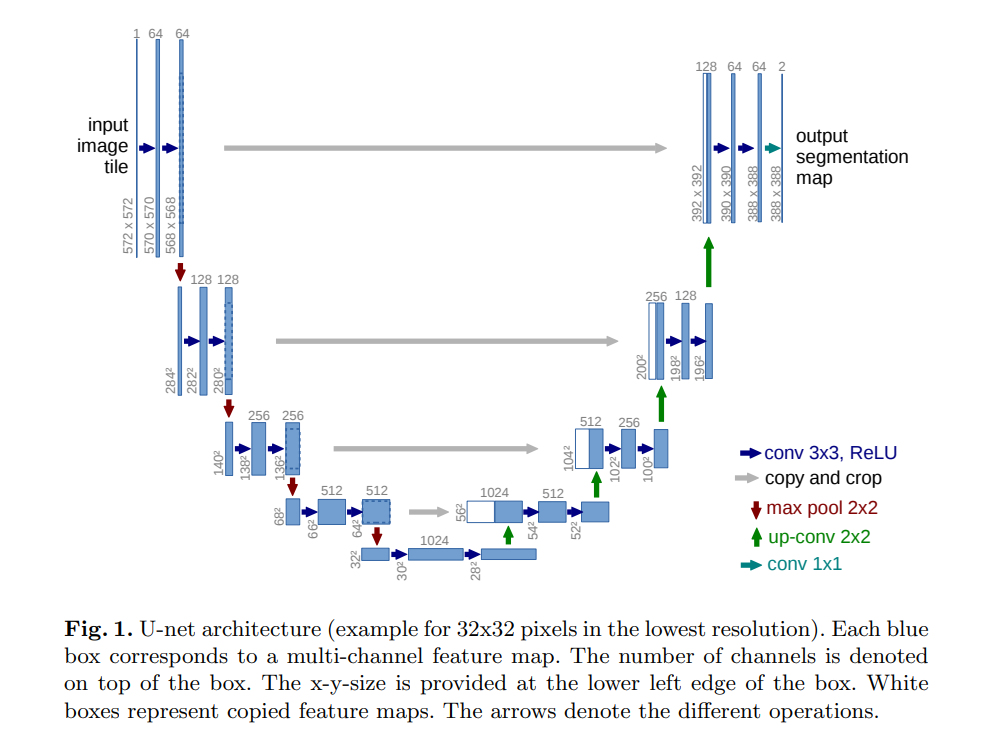